In [1]:
include("utils.jl"); using .Utils
checkpkgs("DataFrames", "Distributions")

## Outer Operations

In [2]:
x = [1, 3, 5]
y = [2, 4]

2-element Vector{Int64}:
 2
 4

In [3]:
# In Julia, we don't really need meshgrid
# However, we can implement it easily with broadcasting:
meshgrid(x, y) = x' .* ones(length(y)), ones(length(x))' .* y

X, Y = meshgrid(x,y);

In [4]:
X

2×3 Matrix{Float64}:
 1.0  3.0  5.0
 1.0  3.0  5.0

In [5]:
Y

2×3 Matrix{Float64}:
 2.0  2.0  2.0
 4.0  4.0  4.0

In [6]:
X .* Y

2×3 Matrix{Float64}:
 2.0   6.0  10.0
 4.0  12.0  20.0

In [7]:
# we can get the outer product more easily with broadcasting:
x' .* y

2×3 Matrix{Int64}:
 2   6  10
 4  12  20

In [8]:
using DataFrames

# a bit convoluted...
make_df(x, y, a) = DataFrame("index" => y, map(i -> string(x[i]) =>a[:, i], 1:length(x))...)

df = make_df(x, y, x' .* y)

,index,1,3,5
,Int64,Int64,Int64,Int64
1,2,2,6,10
2,4,4,12,20


In [9]:
# again, using broadcasting
x' .+ y

2×3 Matrix{Int64}:
 3  5  7
 5  7  9

In [10]:
x' .> y

2×3 BitMatrix:
 0  1  1
 0  0  1

## How Tall Is A?

In [11]:
μ=178
qs = range(μ-24, μ+24, step=0.5);

In [12]:
using Distributions
σ=7.7
ps = pdf.(Normal(μ, σ), qs);

In [13]:
include("empiricaldist.jl"); using .EmpiricalDist

prior = Pmf(ps, qs)
normalize!(prior)

1.9967335172591185

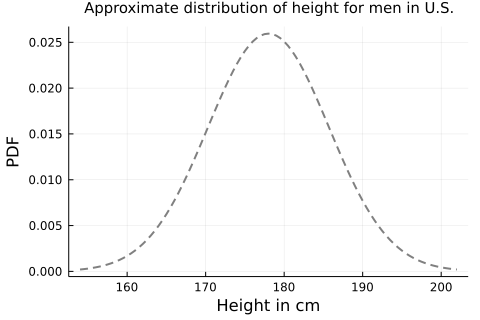

In [14]:
using Plots # default GR backend cuts the heatmap legend
plot(prior, style=:dash, color=:gray,
     xlabel="Height in cm", ylabel="PDF",
     title="Approximate distribution of height for men in U.S.",
     titlefontsize=10)

## Joint Distribution

In [15]:
"""Compute the outer product of two Pmfs."""
make_joint(pmf1, pmf2) = make_df(pmf1.qs, pmf2.qs, pmf1.ps' .* pmf2.ps)

make_joint

In [16]:
joint = make_joint(prior, prior)
size(joint) # the size is *not* the same as Python as we've added an index column and range() returns upper limit

(97, 98)

In [17]:
# we must drop the index column for this to work
sum(Matrix(joint[:, 2:end]))

1.0000000000000002

In [18]:
# in Julia, we need to specify if we're working on rows or columns
series = sum(eachcol(joint[:, 2:end]))
size(series)

(97,)

## Visualizing the Joint Distribution

In [19]:
# helper functions
dftomat(df) = Matrix(df[:, 2:end]) # drop index
columns(df) =  parse.(Float64, names(df)[2:end]) # remove index column and convert back to floats

extractaxes(df) = columns(df), df.index

"""Plot a joint distribution with a color mesh."""
function plot_joint(joint; cmap=cgrad(:blues))
    m = dftomat(joint)
    x, y = extractaxes(joint)

    heatmap(x, y, m, c=cmap, legend=:right, xtickfont=4, ytickfont=4)
    xlabel!("A height in cm")
    ylabel!("B height in cm")
end

plot_joint

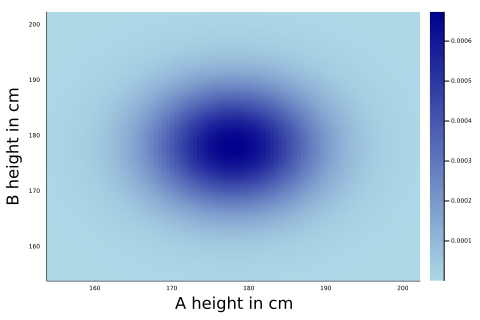

In [20]:
plot_joint(joint)

In [21]:
"""Plot a joint distribution with a contour."""
function plot_contour(joint)
    m = dftomat(joint)
    x, y = extractaxes(joint)
    
    contour(x, y, m, c =cgrad(:haline), levels=4)
    xlabel!("A height in cm")
    ylabel!("B height in cm")
end

plot_contour

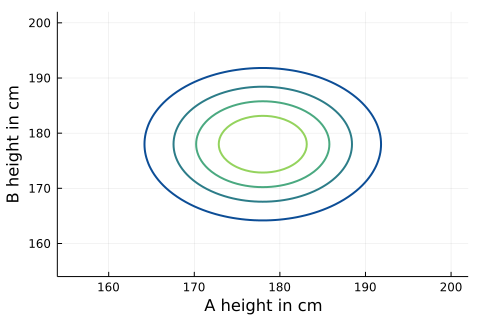

In [22]:
plot_contour(joint)

## Likelihood

In [23]:
# we'll use extractaxes() to extract x, y
x, y = extractaxes(joint);

In [24]:
# there's no real need to build a meshgrid

In [25]:
A_taller = (x' .> y)
eltype(A_taller)

Bool

In [26]:
# Bool is already numeric
a = x' .> y;

In [27]:
likelihood = make_df(x, y, a);

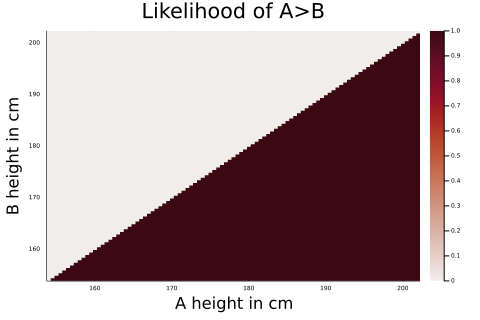

In [28]:
plot_joint(likelihood, cmap=cgrad(:amp))
title!("Likelihood of A>B")

## The Update

In [29]:
# we want to leave the index (first column) alone
function df_update(prior, likelihood)
    x = names(prior)[2:end]
    y = prior.index
    return make_df(x, y, prior[!, 2:end] .* likelihood[!, 2:end])
end
posterior = df_update(joint, likelihood);

In [30]:
"""Normalize a joint distribution."""
function EmpiricalDist.normalize!(joint)
    j = joint[!, 2:end] # we want to leave the index column alone
    prob_data = sum(Matrix(j))
    j ./= prob_data
    return prob_data
end

Main.EmpiricalDist.normalize!

In [31]:
normalize!(posterior)

0.4908111642140922

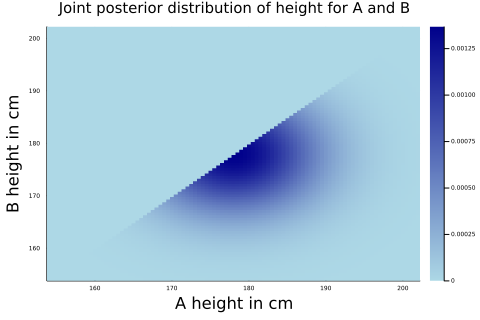

In [32]:
plot_joint(posterior)
title!("Joint posterior distribution of height for A and B", titlefontsize=10)

## Marginal Distributions

In [33]:
# access a column. Column *names* are strings - so we need to convert
# also, to simulate pd.Series, we need to return the index column
function col(df, c)
    n = string(c)
    return DataFrame("index" => df.index, n => df[!, n])
end
column = col(posterior, 180.0)
first(column, 5)

,index,180.0
,Float64,Float64
1,154.0,1.03052e-5
2,154.5,1.25904e-5
3,155.0,1.53177e-5
4,155.5,1.85573e-5
5,156.0,2.23874e-5


In [34]:
sum(column[!, 2]) # sum the 2nd column - i.e. the actual column

0.0301598211109566

In [35]:
# summarize each col (dropping index) and "transpose" (making column names the new index)
function sum_cols(df)
    index = columns(df)
    d = df[!, 2:end] # without index
    s = sum.(eachcol(d)) # summarize by column
    return DataFrame("index"=>index, "sum"=>s)
end

column_sums = sum_cols(posterior);

In [36]:
marginal_A = Pmf(column_sums.sum, column_sums.index);

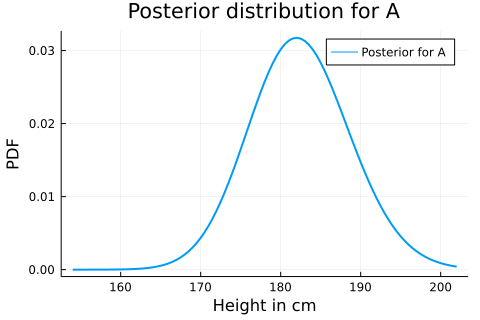

In [37]:
plot(marginal_A, label="Posterior for A",
     xlabel="Height in cm", ylabel="PDF",
     title="Posterior distribution for A")

In [38]:
# summarize each row (keeping index intact)
function sum_rows(df)
    d = df[!, 2:end] # without index
    s = sum.(collect.(eachrow(d))) # summarize by row
    return DataFrame("index"=>df.index, "sum"=>s)
end

row_sums = sum_rows(posterior)
marginal_B = Pmf(row_sums.sum, row_sums.index);

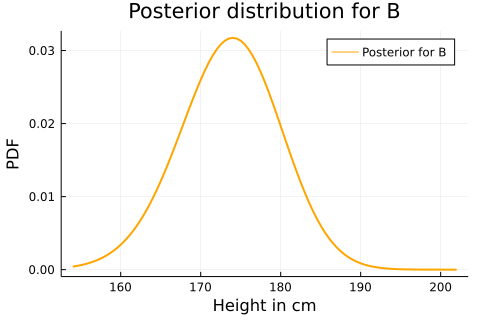

In [39]:
plot(marginal_B, label="Posterior for B", color=:orange,
     xlabel="Height in cm", ylabel="PDF", title="Posterior distribution for B")

In [40]:
"""Compute a marginal distribution."""
function marginal(joint; axis)
    # we'll reuse sum_cols() and sum_rows() from above
    df = (axis == :x) ? sum_cols(joint) : sum_rows(joint)
    return Pmf(df.sum, df.index)
end

marginal

In [41]:
marginal_A = marginal(posterior, axis=:x)
marginal_B = marginal(posterior, axis=:y);

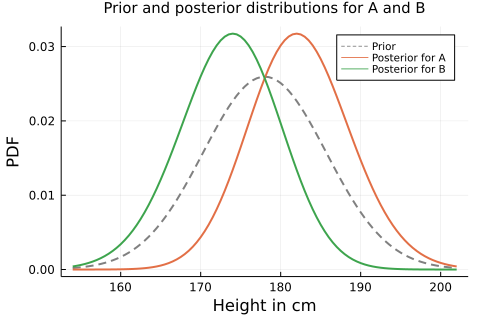

In [42]:
plot(prior, style=:dash, label="Prior", color=:gray)
plot!(marginal_A, label="Posterior for A")
plot!(marginal_B, label="Posterior for B", legendfontsize=7)
plot!(xlabel="Height in cm", ylabel="PDF",
      title="Prior and posterior distributions for A and B", 
      titlefontsize=10, legendfontsize=7)

In [43]:
mean(prior)

178.0

In [44]:
mean(marginal_A), mean(marginal_B)

(182.39533609785371, 173.60466390214629)

In [45]:
std(prior)

7.631769776037863

In [46]:
std(marginal_A), std(marginal_B)

(6.28175518878073, 6.28175518878073)

## Conditional Posteriors

In [47]:
column_170 = col(posterior, 170.0);

In [48]:
cond_B = Pmf(column_170[!, 2], column_170[!, 1]) # column 1 = index; column 2 = value
normalize!(cond_B)

0.004356271367485027

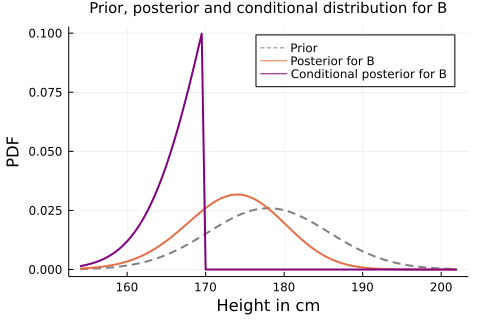

In [49]:
plot(prior, style=:dash, label="Prior", color=:gray)
plot!(marginal_B, label="Posterior for B")
plot!(cond_B, label="Conditional posterior for B", color=:purple)
xlabel!("Height in cm")
ylabel!("PDF")
title!("Prior, posterior and conditional distribution for B", titlefontsize=10)

## Dependence and Independence

## Summary

## Exercises

In [50]:
# 11.1

# we don't need a DataFrame, so we'll directly create a Pmf
function rowtopmf(df, r)
    k = columns(df)
    v = collect(df[findfirst(==(r), df.index), 2:end])
    return Pmf(v, k)
end

cond_A = rowtopmf(posterior, 180.0)
normalize!(cond_A)

0.019671316856828457

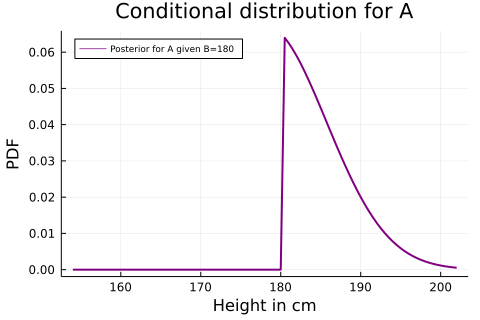

In [51]:
plot(cond_A, label="Posterior for A given B=180", color=:purple,
     xlabel="Height in cm", ylabel="PDF", title="Conditional distribution for A",
     legend=:topleft, legendfontsize=6)

In [52]:
# 11.2

# Here's a prior distribution for the height of
# a randomly chosen woman

μ = 163
qs = range(μ-24, μ+24, step=0.5)

σ = 7.3
ps = pdf.(Normal(μ, σ), qs)

prior_C = Pmf(ps, qs)
normalize!(prior_C)

1.9982161358869277

In [53]:
# Here's the joint prior for A and C

joint_AC = make_joint(marginal_A, prior_C)
size(joint_AC)

(97, 98)

In [54]:
x, y = extractaxes(joint_AC)
a = x' .- y .>= 15
likelihood_AC = make_df(x, y, a);

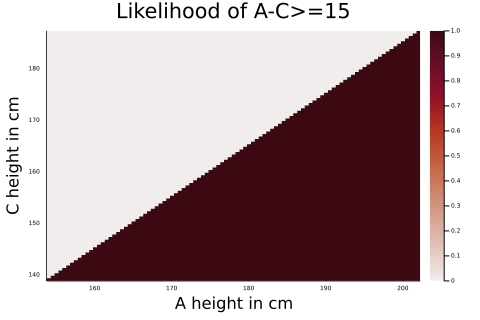

In [55]:
# Here's what the likelihood looks like

plot_joint(likelihood_AC, cmap=cgrad(:amp))
ylabel!("C height in cm")
title!("Likelihood of A-C>=15")

In [56]:
# Here's the update

posterior_AC = df_update(joint_AC, likelihood_AC) # skips index column
normalize!(posterior_AC)

0.6839519266024227

In [57]:
# Here are the marginal posterior distributions

marginal_AC = marginal(posterior_AC, axis=:x)
marginal_C = marginal(posterior_AC, axis=:y);

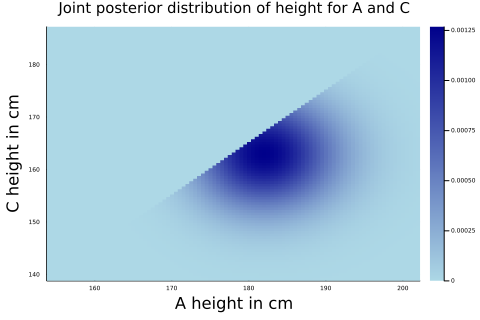

In [58]:
# And the joint posterior

plot_joint(posterior_AC)
ylabel!("C height in cm")
title!("Joint posterior distribution of height for A and C", titlefontsize=10)

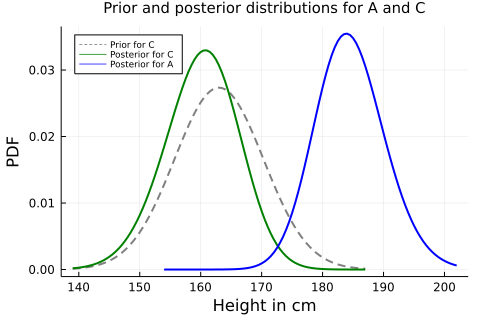

In [59]:
# And here's what they look like

plot(prior_C, style=:dash, label="Prior for C", color=:gray)
plot!(marginal_C, label="Posterior for C", color=:green)
plot!(marginal_AC, label="Posterior for A", color=:blue)
xlabel!("Height in cm")
ylabel!("PDF")
title!("Prior and posterior distributions for A and C", legend=:topleft, legendfontsize=6, titlefontsize=10)

In [60]:
# 11.3
1 / (1 + 10^(-100/400))

0.6400649998028851

In [61]:
# Here are the priors for A and B

qs = range(1300.0, 1900, step=10)
ps = pdf.(Normal(1600, 100),qs)
prior_A_elo = Pmf(ps, qs)
normalize!(prior_A_elo)

qs = range(1500.0, 2100, step=10)
ps = pdf.(Normal(1800, 100),qs)
prior_B_elo = Pmf(ps, qs)
normalize!(prior_B_elo)

0.09977212516898111

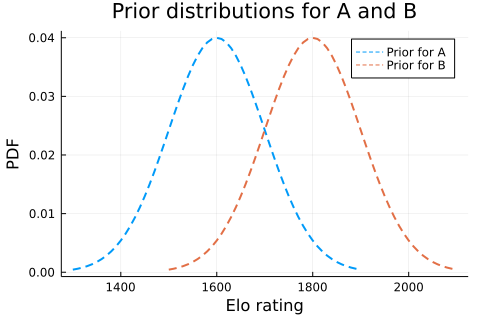

In [62]:
# Here's what the priors look like

plot(prior_A_elo, style=:dash, label="Prior for A")
plot!(prior_B_elo, style=:dash, label="Prior for B")

xlabel!("Elo rating")
ylabel!("PDF")
title!("Prior distributions for A and B")

In [63]:
# Here is the joint prior distribution

joint_elo = make_joint(prior_A_elo, prior_B_elo)
size(joint_elo)

(61, 62)

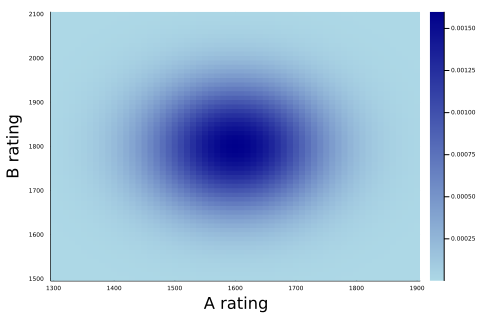

In [64]:
# And here's what it looks like

plot_joint(joint_elo)
xlabel!("A rating")
ylabel!("B rating")

In [65]:
# we can compute difference by rank

x, y = extractaxes(joint_elo)
diff = x' .- y;

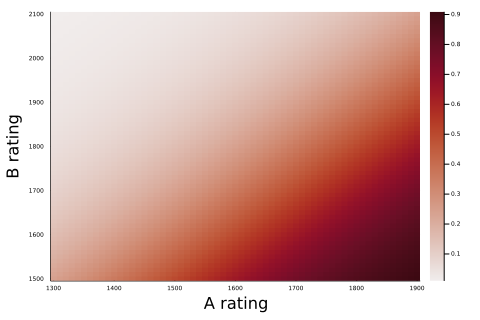

In [66]:
# And here are the likelihoods

a = 1 ./ (1 .+ 10 .^ ( .- diff ./ 400))
likelihood_elo = make_df(x, y, a)

plot_joint(likelihood_elo, cmap=cgrad(:amp))   
xlabel!("A rating")
ylabel!("B rating")

In [67]:

# Here's the update

posterior_elo = df_update(joint_elo,likelihood_elo)
normalize!(posterior_elo)

0.2661134695634803

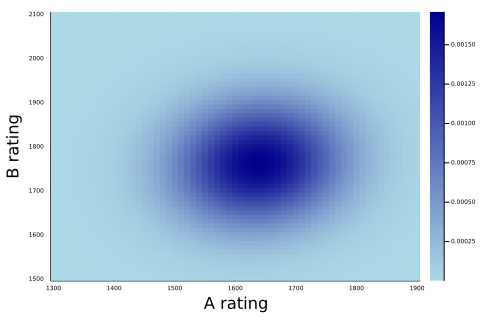

In [68]:
# Here's what the joint posterior looks like

plot_joint(posterior_elo)   
xlabel!("A rating")
ylabel!("B rating")

In [69]:
marginal_A_elo = marginal(posterior_elo, axis=:x)
marginal_B_elo = marginal(posterior_elo, axis=:y);

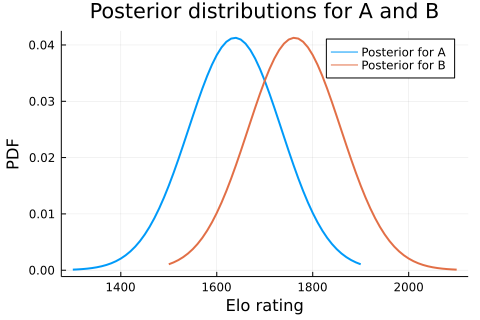

In [70]:
# Here's what they look like

plot(marginal_A_elo, label="Posterior for A")
plot!(marginal_B_elo, label="Posterior for B")
xlabel!("Elo rating")
ylabel!("PDF")
title!("Posterior distributions for A and B")

In [71]:
# Posterior means

mean(marginal_A_elo), mean(marginal_B_elo)

(1636.9271138245565, 1763.0728861754444)

In [72]:
# Posterior standard deviation

std(marginal_A_elo), std(marginal_B_elo)

(95.67265606582816, 95.67265606582816)